# AI in Medicine I - Practical 3: Transfer Learning

Generating good labels for medical datasets is an expensive and time consuming task, especially on tasks such as segmentation where expert radiologists are often required.
Often we are faced with datasets that have scarce labels or none at all and must rely on selfsupervised pretraining methods to increase our performance.
We will continue to use the brain MRI dataset from the previous practicals.
The Jupyter Notebook provided contains some preliminary code you can use and some function prototypes that you are expected to fill in.
The deliverables for the submission an archive containing the code provided completed as well as a short report explaining your strategies and choices for each task in this practical.


**Make sure to select the correct runtime when working in Google Colab (GPU)**

### Read the text descriptions and code cells carefully and look out for the cells marked with 'TASK' and 'ADD YOUR CODE HERE'.

In [ ]:
# # Only run this cell when in Google Colab
# ! git init
# ! git remote add origin https://github.com/compai-lab/aim-practical-3-transfer-learning
# ! git fetch
# ! git checkout -t origin/main

## Downloading the Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab\ Notebooks/AIMpractical3

/content/drive/MyDrive/Colab Notebooks/AIMpractical3


In [ ]:
!pwd

/content/drive/MyDrive/Colab Notebooks/AIMpractical3


In [ ]:
# ! wget https://www.dropbox.com/s/w9njau9t6rrheel/brainage-data.zip
# ! unzip brainage-data.zip
# ! wget https://www.dropbox.com/s/f5mt8p9pkszff3x/brainage-testdata.zip
# ! unzip brainage-testdata.zip

--2022-11-28 22:35:28--  https://www.dropbox.com/s/w9njau9t6rrheel/brainage-data.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/w9njau9t6rrheel/brainage-data.zip [following]
--2022-11-28 22:35:28--  https://www.dropbox.com/s/raw/w9njau9t6rrheel/brainage-data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6c309562a7822176ff8428ce60.dl.dropboxusercontent.com/cd/0/inline/Bxobb6AY54ORFRT2hN5fZ98iLDcJkWkRCpXE2E8okoyX6vxjx0UGj9tJb4y9VfuANIU0fRacQsoNrpSPFGuNXKbFVLfGGDAXqWfGn-E3n7njwhdWbYdFq2ZL0YEUlpt0JHGjMFikRz-y2kVjJ3hY3RK7_gJDBZ820NulgZGUGtnufw/file# [following]
--2022-11-28 22:35:29--  https://uc6c309562a7822176ff8428ce60.dl.dropboxusercontent.com/cd/0/inline/Bxobb6AY54ORFRT2hN5fZ98iLDcJkWkRCpXE2E8okoyX6vxjx0UGj9tJb4y9VfuAN

In [3]:
! pip install monai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 14.4 MB/s 


## Imports

In [4]:
from argparse import Namespace

import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import Tensor


from monai.networks.nets import UNet
from monai.losses import DiceCELoss
from monai.transforms import AsDiscrete
from monai.metrics import compute_dice


from data_utils import get_image_dataloaders
from utils import AvgMeter, seed_everything
%load_ext tensorboard
%load_ext autoreload
%autoreload 2


## Getting started and familiarise ourselves with the data

We provide the data of 652 subjects from which we use 500 for training, 47 for validation, and the rest for testing your final model.
The following cells provide helper functions to load the data and provide an overview and visualization of the statistics over the total population of the 652 subjects.

In [5]:
train_df = pd.read_csv('./data/brain_age/meta/meta_data_regression_train.csv')
val_df = pd.read_csv('./data/brain_age/meta/meta_data_segmentation_train.csv')
test_df = pd.read_csv('./data/brain_age/meta/meta_data_regression_test.csv')
train_df['subject_id']
id_overlap = pd.merge(train_df, val_df, on='subject_id', how='inner')
assert len(id_overlap)==0
id_overlap = pd.merge(train_df, test_df, on='subject_id', how='inner')
assert len(id_overlap)==0
id_overlap = pd.merge(val_df, test_df, on='subject_id', how='inner')
assert len(id_overlap)==0

## Segmentation

We again wish to segment our brains using deep neural network. The following code is a basic example of how to do so.

### Full Dataset Results

In [6]:
def train_segmentation(config, model, optimizer, train_loader, val_loader):
    model.train()
    step = 0
    checks = 0
    best_val_loss = float('Inf')
    avg_loss = AvgMeter()
    avg_dice = AvgMeter()
    
    criterion = DiceCELoss(include_background=False, softmax=True)
    postprocess = AsDiscrete(argmax=True, to_onehot=4)


    while True: 
        for x, y in train_loader:
            x = x.to(config.device)
            y = y.to(config.device)

            # Training step
            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()

            pred_binarized = []
            y_binarized = []
            for i in range(pred.shape[0]):
                pred_binarized.append(postprocess(pred[i]))
                y_binarized.append(postprocess(y[i]))
            pred_binarized = torch.stack(pred_binarized)
            y_binarized = torch.stack(y_binarized)

            dice = compute_dice(pred_binarized, y_binarized, include_background=False).mean()

            avg_loss.add(loss.detach().item())
            avg_dice.add(dice.detach().item())

            # Increment step
            step += 1

            if step % config.log_freq == 0 and not step % config.val_freq == 0:
                train_loss = avg_loss.compute()
                train_dice = avg_dice.compute()

            # Validate and log at validation frequency
            if step % config.val_freq == 0:
                # Reset avg_loss
                train_loss = avg_loss.compute()
                train_dice = avg_dice.compute()
                avg_loss = AvgMeter()
                avg_dice = AvgMeter()

                # Get validation results
                val_results = validate_segmentation(
                    model,
                    val_loader,
                    config,
                    criterion,
                    postprocess
                )

                # Print current performance
                print(f"Finished step {step} of {config.num_steps}. "
                      f"Train loss: {train_loss} - "
                      f"Train Dice: {train_dice} - "
                      f"val loss: {val_results['val/loss']:.4f} - "
                      f"val Dice: {val_results['val/Dice']:.4f} - "
                      f"val Dice_CSF: {val_results['val/Dice_CSF']:.4f} - "
                      f"val Dice_WM: {val_results['val/Dice_WM']:.4f} - "
                      f"val Dice_GM: {val_results['val/Dice_GM']:.4f} - "
                      f"patience: {checks}" )

                # Check if the validation loss has stopped increasing
                ### ADD YOUR CODE HERE ###

                if val_results['val/loss'] < best_val_loss:
                  checks = 0
                  best_val_loss = val_results['val/loss']
                else:
                  checks += 1
            if checks > config.patience: 
              print(f'\nEarly stopped, Finished training after {step} steps\n')
              return model, step

                ### END ###
            
            
            if step >= config.num_steps:
                print(f'\nFinished training after {step} steps\n')
                return model, step


def validate_segmentation(model, val_loader, config, criterion, postprocess):
    model.eval()
    avg_val_loss = AvgMeter()
    avg_val_dice = AvgMeter()
    avg_val_dice_1 = AvgMeter()
    avg_val_dice_2 = AvgMeter()
    avg_val_dice_3 = AvgMeter()
    for x, y in val_loader:
        x = x.to(config.device)
        y = y.to(config.device)

        with torch.no_grad():
            pred = model(x)    
        loss = criterion(pred, y)
        
        pred_binarized = []
        y_binarized = []
        for i in range(pred.shape[0]):
            pred_binarized.append(postprocess(pred[i]))
            y_binarized.append(postprocess(y[i]))
        pred_binarized = torch.stack(pred_binarized)
        y_binarized = torch.stack(y_binarized)

        dice = compute_dice(pred_binarized, y_binarized, include_background=False)
        mean_dice = dice.mean()
        mean_dice_per_class = dice.mean(dim=0)
        avg_val_loss.add(loss.item())
        avg_val_dice.add(mean_dice.item())
        avg_val_dice_1.add(mean_dice_per_class[0].item())
        avg_val_dice_2.add(mean_dice_per_class[1].item())
        avg_val_dice_3.add(mean_dice_per_class[2].item())

        
    model.train()
    return {
        'val/loss': avg_val_loss.compute(),
        'val/Dice': avg_val_dice.compute(),
        'val/Dice_CSF': avg_val_dice_1.compute(),
        'val/Dice_WM': avg_val_dice_2.compute(),
        'val/Dice_GM': avg_val_dice_3.compute()
    }


In [7]:
# Lets set some basic hyperparameters
config = Namespace()
config.img_size = 96
config.batch_size = 16
config.num_workers = 0

config.log_dir = './logs'
config.val_freq = 50
config.log_freq = 10

config.seed = 0
config.device = 'cuda'
config.autoencoder = False

config.lr = 1e-3
config.betas = (0.9, 0.999)

config.num_steps = 5000
config.patience = 5

seed_everything(config.seed)


In [8]:
import pandas as pd
all_train_df = pd.read_csv('./data/brain_age/meta/meta_data_regression_train.csv')
low_data_train_df = all_train_df.sample(n=200, random_state=12)
low_data_train_df.to_csv('./data/brain_age/meta/meta_data_regression_train_lowdata_200.csv', index=False)

In [9]:
# Load data
dataloaders_fulldata_segmentations = get_image_dataloaders(
    img_size=config.img_size,
    batch_size=config.batch_size,
    num_workers=config.num_workers,
    segmentations = True,
    low_data = '200'
)

Loading data. This might take a while...
Loading train_lowdata_200 data...
Loading val data...
Loading test data...


#### TASK: MONAI UNET
For todays exercise we will be using a library called MONAI which has some very useful tools for medical imaging. Our task is segmentation and so we will be using a classic UNet. Think about how many channels, strides and residual unets you want to include. Remember that for smaller datasets, less parameters is often an advantage. Play around with different settings and see how the performance changes.

In [ ]:
# Init model
model_unet = UNet(
  spatial_dims=3,
  out_channels=4,
  ### ADD YOUR CODE HERE ###
  in_channels =1,
  channels = (4, 8, 16, 32, 64),
  strides = (2, 2, 2, 2),
  kernel_size = 3,
  up_kernel_size = 3

  ### END ###
).to(config.device)


# Init optimizers
optimizer = torch.optim.AdamW(
    model_unet.parameters(),
    lr=config.lr,
    betas=config.betas
)

model_unet, step = train_segmentation(
    config=config,
    model=model_unet,
    optimizer=optimizer,
    train_loader=dataloaders_fulldata_segmentations['train'],
    val_loader=dataloaders_fulldata_segmentations['val']
)

Finished step 50 of 5000. Train loss: 2.0206420040130615 - Train Dice: 0.33934983536601065 - val loss: 1.7676 - val Dice: 0.5571 - val Dice_CSF: 0.6278 - val Dice_WM: 0.5588 - val Dice_GM: 0.4848 - patience: 0
Finished step 100 of 5000. Train loss: 1.5749304103851318 - Train Dice: 0.642943091392517 - val loss: 1.4071 - val Dice: 0.6959 - val Dice_CSF: 0.6899 - val Dice_WM: 0.7156 - val Dice_GM: 0.6824 - patience: 0
Finished step 150 of 5000. Train loss: 1.283093602657318 - Train Dice: 0.7207265615463256 - val loss: 1.1709 - val Dice: 0.7368 - val Dice_CSF: 0.7179 - val Dice_WM: 0.7593 - val Dice_GM: 0.7330 - patience: 0
Finished step 200 of 5000. Train loss: 1.080471739768982 - Train Dice: 0.7511707782745362 - val loss: 0.9976 - val Dice: 0.7587 - val Dice_CSF: 0.7347 - val Dice_WM: 0.7788 - val Dice_GM: 0.7625 - patience: 0
Finished step 250 of 5000. Train loss: 0.9278871095180512 - Train Dice: 0.7660333001613617 - val loss: 0.8635 - val Dice: 0.7693 - val Dice_CSF: 0.7432 - val Dice_

In [ ]:
# Test
test_results = validate_segmentation(model_unet, dataloaders_fulldata_segmentations['test'], config, DiceCELoss(include_background=False, softmax=True), AsDiscrete(argmax=True, to_onehot=4))
print(f'Test loss: {test_results["val/loss"]:.4f}')
print(f'Test Mean Dice: {test_results["val/Dice"]:.4f}')
print(f'Test Dice_CSF: {test_results["val/Dice_CSF"]:.4f}')
print(f'Test Dice_WM: {test_results["val/Dice_WM"]:.4f}')
print(f'Test Dice_GM: {test_results["val/Dice_GM"]:.4f}')

Test loss: 0.2880
Test Mean Dice: 0.8338
Test Dice_CSF: 0.8068
Test Dice_WM: 0.8549
Test Dice_GM: 0.8397


### TASK: Low Label Simulation

Often we don't have labels for all of our samples, or have multiple datasets, where we might have labels for one dataset but not the other. 
Especially in medicine, where expert labels can be expensive to generate, we have to combine datasets to have enough data for training. 

Here we will simulate the scenario that our radiologists don't like us and have decided to only segment three brains.

Retrain the model and see what happens to our test results.

In [10]:
import pandas as pd
all_train_df = pd.read_csv('./data/brain_age/meta/meta_data_regression_train.csv')
low_data_train_df = all_train_df.sample(n=3, random_state=12)
low_data_train_df.to_csv('./data/brain_age/meta/meta_data_regression_train_lowdata_3.csv', index=False)

In [11]:
dataloaders_lowdata_segmentations = get_image_dataloaders(
    img_size=config.img_size,
    batch_size=config.batch_size,
    num_workers=config.num_workers,
    low_data= '3',
    segmentations = True,
    train_only = True
)

Loading data. This might take a while...
Loading train_lowdata_3 data...


In [ ]:
model_unet_lowdata = UNet(
  spatial_dims=3,
  out_channels=4,
### ADD YOUR CODE HERE ###
  in_channels =1,
  channels = (4, 8, 16),
  strides = (2, 2),
  kernel_size = 3,
  up_kernel_size = 3
### END ###
).to(config.device)


# Init optimizers
optimizer = torch.optim.AdamW(
    model_unet_lowdata.parameters(),
    lr=config.lr,
    betas=config.betas
)

config.patience = 5
config.num_steps = 5000
model_unet_lowdata, step = train_segmentation(
    config=config,
    model=model_unet_lowdata,
    optimizer=optimizer,
    train_loader=dataloaders_lowdata_segmentations['train'],
    val_loader=dataloaders_fulldata_segmentations['val']
)

Finished step 50 of 5000. Train loss: 2.0047403216362 - Train Dice: 0.37415216624736786 - val loss: 1.7701 - val Dice: 0.4750 - val Dice_CSF: 0.5878 - val Dice_WM: 0.5834 - val Dice_GM: 0.2538 - patience: 0
Finished step 100 of 5000. Train loss: 1.5910963320732117 - Train Dice: 0.5841931802034378 - val loss: 1.4405 - val Dice: 0.6387 - val Dice_CSF: 0.6559 - val Dice_WM: 0.6892 - val Dice_GM: 0.5710 - patience: 0
Finished step 150 of 5000. Train loss: 1.3148793601989746 - Train Dice: 0.6999865353107453 - val loss: 1.2169 - val Dice: 0.7043 - val Dice_CSF: 0.6951 - val Dice_WM: 0.7326 - val Dice_GM: 0.6852 - patience: 0
Finished step 200 of 5000. Train loss: 1.1251501941680908 - Train Dice: 0.7465613901615142 - val loss: 1.0621 - val Dice: 0.7301 - val Dice_CSF: 0.7163 - val Dice_WM: 0.7504 - val Dice_GM: 0.7235 - patience: 0
Finished step 250 of 5000. Train loss: 0.9866197407245636 - Train Dice: 0.764976818561554 - val loss: 0.9450 - val Dice: 0.7405 - val Dice_CSF: 0.7260 - val Dice_W

In [ ]:
# Test
test_results = validate_segmentation(model_unet_lowdata, dataloaders_fulldata_segmentations['test'], config, DiceCELoss(include_background=False, softmax=True), AsDiscrete(argmax=True, to_onehot=4))
print(f'Test loss: {test_results["val/loss"]:.4f}')
print(f'Test Mean Dice: {test_results["val/Dice"]:.4f}')
print(f'Test Dice_CSF: {test_results["val/Dice_CSF"]:.4f}')
print(f'Test Dice_WM: {test_results["val/Dice_WM"]:.4f}')
print(f'Test Dice_GM: {test_results["val/Dice_GM"]:.4f}')

Test loss: 0.4372
Test Mean Dice: 0.7674
Test Dice_CSF: 0.7484
Test Dice_WM: 0.7965
Test Dice_GM: 0.7574


In [ ]:
model_unet_lowdata = UNet(
  spatial_dims=3,
  out_channels=4,
### ADD YOUR CODE HERE ###
  in_channels =1,
  channels = (4, 8, 16),
  strides = (2, 2),
  kernel_size = 3,
  up_kernel_size = 3
### END ###
).to(config.device)


# Init optimizers
optimizer = torch.optim.AdamW(
    model_unet_lowdata.parameters(),
    lr=config.lr,
    betas=config.betas
)

config.patience = 2
config.num_steps = 5000
model_unet_lowdata, step = train_segmentation(
    config=config,
    model=model_unet_lowdata,
    optimizer=optimizer,
    train_loader=dataloaders_lowdata_segmentations['train'],
    val_loader=dataloaders_fulldata_segmentations['val']
)

Finished step 50 of 5000. Train loss: 2.0890831255912783 - Train Dice: 0.3064438600838184 - val loss: 1.8322 - val Dice: 0.4327 - val Dice_CSF: 0.6293 - val Dice_WM: 0.6679 - val Dice_GM: 0.0010 - patience: 0
Finished step 100 of 5000. Train loss: 1.6402949333190917 - Train Dice: 0.5008826947212219 - val loss: 1.4682 - val Dice: 0.5658 - val Dice_CSF: 0.7054 - val Dice_WM: 0.7057 - val Dice_GM: 0.2864 - patience: 0
Finished step 150 of 5000. Train loss: 1.3267465901374818 - Train Dice: 0.6783554089069367 - val loss: 1.2123 - val Dice: 0.7055 - val Dice_CSF: 0.7265 - val Dice_WM: 0.7475 - val Dice_GM: 0.6425 - patience: 0
Finished step 200 of 5000. Train loss: 1.1083140397071838 - Train Dice: 0.7394355928897858 - val loss: 1.0299 - val Dice: 0.7357 - val Dice_CSF: 0.7355 - val Dice_WM: 0.7549 - val Dice_GM: 0.7168 - patience: 0
Finished step 250 of 5000. Train loss: 0.9471816992759705 - Train Dice: 0.7639013504981995 - val loss: 0.8929 - val Dice: 0.7476 - val Dice_CSF: 0.7404 - val Dic

In [ ]:
# Test
test_results = validate_segmentation(model_unet_lowdata, dataloaders_fulldata_segmentations['test'], config, DiceCELoss(include_background=False, softmax=True), AsDiscrete(argmax=True, to_onehot=4))
print(f'Test loss: {test_results["val/loss"]:.4f}')
print(f'Test Mean Dice: {test_results["val/Dice"]:.4f}')
print(f'Test Dice_CSF: {test_results["val/Dice_CSF"]:.4f}')
print(f'Test Dice_WM: {test_results["val/Dice_WM"]:.4f}')
print(f'Test Dice_GM: {test_results["val/Dice_GM"]:.4f}')

Test loss: 0.4051
Test Mean Dice: 0.7671
Test Dice_CSF: 0.7490
Test Dice_WM: 0.7833
Test Dice_GM: 0.7690


In [ ]:
model_unet_lowdata = UNet(
  spatial_dims=3,
  out_channels=4,
### ADD YOUR CODE HERE ###
  in_channels =1,
  channels = (4, 8, 16),
  strides = (2, 2),
  kernel_size = 3,
  up_kernel_size = 3
### END ###
).to(config.device)


# Init optimizers
optimizer = torch.optim.AdamW(
    model_unet_lowdata.parameters(),
    lr=config.lr,
    betas=config.betas
)

config.patience = 7
config.num_steps = 5000
model_unet_lowdata, step = train_segmentation(
    config=config,
    model=model_unet_lowdata,
    optimizer=optimizer,
    train_loader=dataloaders_lowdata_segmentations['train'],
    val_loader=dataloaders_fulldata_segmentations['val']
)

Finished step 50 of 5000. Train loss: 2.044756741523743 - Train Dice: 0.3825887855887413 - val loss: 1.8274 - val Dice: 0.4680 - val Dice_CSF: 0.6090 - val Dice_WM: 0.6633 - val Dice_GM: 0.1318 - patience: 0
Finished step 100 of 5000. Train loss: 1.6533211946487427 - Train Dice: 0.5903413105010986 - val loss: 1.4972 - val Dice: 0.6582 - val Dice_CSF: 0.6692 - val Dice_WM: 0.7255 - val Dice_GM: 0.5799 - patience: 0
Finished step 150 of 5000. Train loss: 1.375059666633606 - Train Dice: 0.709506630897522 - val loss: 1.2740 - val Dice: 0.7080 - val Dice_CSF: 0.7047 - val Dice_WM: 0.7457 - val Dice_GM: 0.6735 - patience: 0
Finished step 200 of 5000. Train loss: 1.1840039086341858 - Train Dice: 0.7413312828540802 - val loss: 1.1149 - val Dice: 0.7311 - val Dice_CSF: 0.7213 - val Dice_WM: 0.7564 - val Dice_GM: 0.7156 - patience: 0
Finished step 250 of 5000. Train loss: 1.0390527880191802 - Train Dice: 0.7638667178153992 - val loss: 0.9904 - val Dice: 0.7453 - val Dice_CSF: 0.7325 - val Dice_W

In [ ]:
# Test
test_results = validate_segmentation(model_unet_lowdata, dataloaders_fulldata_segmentations['test'], config, DiceCELoss(include_background=False, softmax=True), AsDiscrete(argmax=True, to_onehot=4))
print(f'Test loss: {test_results["val/loss"]:.4f}')
print(f'Test Mean Dice: {test_results["val/Dice"]:.4f}')
print(f'Test Dice_CSF: {test_results["val/Dice_CSF"]:.4f}')
print(f'Test Dice_WM: {test_results["val/Dice_WM"]:.4f}')
print(f'Test Dice_GM: {test_results["val/Dice_GM"]:.4f}')

Test loss: 0.4111
Test Mean Dice: 0.7732
Test Dice_CSF: 0.7602
Test Dice_WM: 0.7960
Test Dice_GM: 0.7633


### TASK: What happens to our training dynamics and duration now that we have less data? 

Maybe setting a fixed amount of steps is not the best idea...
Implement some form of early stopping in the training loop that stops training after the validation loss does not improve after N checks.
Play around with this patience parameter. How does it affect test accuracy? Why?

Retrain the model

In [24]:
model_unet_lowdata = UNet(
  spatial_dims=3,
  out_channels=4,
### ADD YOUR CODE HERE ###
  in_channels =1,
  channels = (4, 8, 16),
  strides = (2, 2),
  kernel_size = 3,
  up_kernel_size = 3,
  num_res_units = 5

### END ###
).to(config.device)


# Init optimizers
optimizer = torch.optim.AdamW(
    model_unet_lowdata.parameters(),
    lr=config.lr,
    betas=config.betas
)

config.patience = 5
config.num_steps = 500
model_unet_lowdata, step = train_segmentation(
    config=config,
    model=model_unet_lowdata,
    optimizer=optimizer,
    train_loader=dataloaders_lowdata_segmentations['train'],
    val_loader=dataloaders_fulldata_segmentations['val']
)

Finished step 50 of 500. Train loss: 1.4481398630142213 - Train Dice: 0.26652358695864675 - val loss: 0.9475 - val Dice: 0.3904 - val Dice_CSF: 0.5601 - val Dice_WM: 0.5358 - val Dice_GM: 0.0751 - patience: 0
Finished step 100 of 500. Train loss: 0.7745167064666748 - Train Dice: 0.5269404309988022 - val loss: 0.6388 - val Dice: 0.6742 - val Dice_CSF: 0.6862 - val Dice_WM: 0.7038 - val Dice_GM: 0.6325 - patience: 0
Finished step 150 of 500. Train loss: 0.5192645519971848 - Train Dice: 0.7346134042739868 - val loss: 0.4738 - val Dice: 0.7458 - val Dice_CSF: 0.7252 - val Dice_WM: 0.7547 - val Dice_GM: 0.7574 - patience: 0
Finished step 200 of 500. Train loss: 0.40031092286109926 - Train Dice: 0.7835050737857818 - val loss: 0.4258 - val Dice: 0.7617 - val Dice_CSF: 0.7458 - val Dice_WM: 0.7782 - val Dice_GM: 0.7612 - patience: 0
Finished step 250 of 500. Train loss: 0.34459648609161375 - Train Dice: 0.8098545253276825 - val loss: 0.3973 - val Dice: 0.7761 - val Dice_CSF: 0.7572 - val Dice_

In [25]:
# Test
test_results = validate_segmentation(model_unet_lowdata, dataloaders_fulldata_segmentations['test'], config, DiceCELoss(include_background=False, softmax=True), AsDiscrete(argmax=True, to_onehot=4))
print(f'Test loss: {test_results["val/loss"]:.4f}')
print(f'Test Mean Dice: {test_results["val/Dice"]:.4f}')
print(f'Test Dice_CSF: {test_results["val/Dice_CSF"]:.4f}')
print(f'Test Dice_WM: {test_results["val/Dice_WM"]:.4f}')
print(f'Test Dice_GM: {test_results["val/Dice_GM"]:.4f}')

Test loss: 0.4203
Test Mean Dice: 0.7598
Test Dice_CSF: 0.7563
Test Dice_WM: 0.7905
Test Dice_GM: 0.7326


### TASK: Autoencoder

We can't seem to achieve our previous performance because we don't have enough labeled samples. We still have the rest of the data, we just don't have any labels. Maybe we can improve our performance by doing some initial unsupervised learning over the full, unlabeled dataset before finetuning on our three labeled samples.

In [14]:
def train_autoencoder(config, model, optimizer, train_loader, val_loader):
    model.train()
    step = 0
    avg_loss = AvgMeter()

    while True:
        for x, y in train_loader:
            x = x.to(config.device)
            y = y.to(config.device)
            

            # Training step
            optimizer.zero_grad()
            pred = model(x)
            loss = torch.pow((pred - x), 2).mean()
            loss.backward()
            optimizer.step()

            avg_loss.add(loss.detach().item())

            # Increment step
            step += 1

            # Validate and log at validation frequency
            if step % config.val_freq == 0:
                # Reset avg_loss
                train_loss = avg_loss.compute()
                avg_loss = AvgMeter()

                # Get validation results
                val_results = validate_autoencoder(
                    model,
                    val_loader,
                    config
                )

                # Print current performance
                print(f"Finished step {step} of {config.num_steps}. "
                      f"Train loss: {train_loss} - "
                      f"val loss: {val_results['val/loss']:.4f} - "
                      f"val MAE: {val_results['val/MAE']:.4f}")

            if step >= config.num_steps:
                print(f'\nFinished training after {step} steps\n')
                return model, step


def validate_autoencoder(model, val_loader, config, show_plot=False):
    model.eval()
    avg_val_loss = AvgMeter()
    preds = []
    targets = []
    for x, y in val_loader:
        x = x.to(config.device)
        y = y.to(config.device)

        with torch.no_grad():
            pred = model(x)
        loss = torch.pow((pred - x), 2).mean()
        avg_val_loss.add(loss.item())
        preds.append(pred.cpu())
        targets.append(x.cpu())

    preds = torch.cat(preds)
    targets = torch.cat(targets)
    mae = mean_absolute_error_image(preds, targets)
        
    model.train()
    return {
        'val/loss': avg_val_loss.compute(),
        'val/MAE': mae,
    }


def mean_absolute_error_image(preds: Tensor, targets: Tensor) -> float:
    """Compute the mean absolute error between predictions and targets"""
    return (preds - targets).abs().mean().item()


In [35]:
# Init model
# HINT: If you aren´t getting the performance you expect, try to change the number of channels and the number of res units
model_ae = UNet(
  ### ADD YOUR CODE HERE ###

  spatial_dims=3,
  in_channels =1,
  out_channels=1,
  channels = (4, 8, 16, 32, 64, 128),
  strides = (2, 2, 2, 2, 2),
  kernel_size = 3,
  up_kernel_size = 3,
  num_res_units = 7

  ### END ###
).to(config.device)

# Init optimizers
optimizer = torch.optim.AdamW(
    model_ae.parameters(),
    lr=config.lr,
    betas=config.betas
)

config.num_steps = 3000
model_ae, step = train_autoencoder(
    config=config,
    model=model_ae,
    optimizer=optimizer,
    train_loader=dataloaders_fulldata_segmentations['train'],
    val_loader=dataloaders_fulldata_segmentations['val']
)

Finished step 50 of 3000. Train loss: 0.15579740062355996 - val loss: 0.0585 - val MAE: 0.1553
Finished step 100 of 3000. Train loss: 0.041058843322098255 - val loss: 0.0270 - val MAE: 0.1048
Finished step 150 of 3000. Train loss: 0.02013108044862747 - val loss: 0.0143 - val MAE: 0.0721
Finished step 200 of 3000. Train loss: 0.012108829095959664 - val loss: 0.0099 - val MAE: 0.0510
Finished step 250 of 3000. Train loss: 0.009239509869366884 - val loss: 0.0081 - val MAE: 0.0404
Finished step 300 of 3000. Train loss: 0.007734621316194535 - val loss: 0.0069 - val MAE: 0.0357
Finished step 350 of 3000. Train loss: 0.006699055097997188 - val loss: 0.0060 - val MAE: 0.0337
Finished step 400 of 3000. Train loss: 0.005911267930641771 - val loss: 0.0054 - val MAE: 0.0315
Finished step 450 of 3000. Train loss: 0.005336043983697891 - val loss: 0.0049 - val MAE: 0.0298
Finished step 500 of 3000. Train loss: 0.004865163238719106 - val loss: 0.0045 - val MAE: 0.0286
Finished step 550 of 3000. Train 

#### TASK: Visualize Results

Plot both the original brains and the reconstructed brains above one another to see how good the autoencoder performed

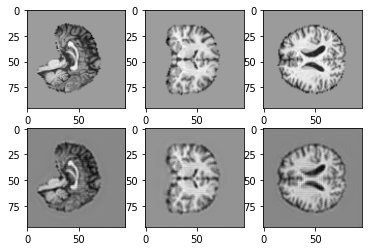

In [36]:
orig_images = next(iter(dataloaders_fulldata_segmentations['val']))[0].to(config.device)

f, axarr = plt.subplots(2, 3)
orig_image = orig_images[0, 0].cpu().numpy()
H, W, D = orig_image.shape
axarr[0][0].imshow(orig_image[H // 2, :, :], cmap='gray')
axarr[0][1].imshow(orig_image[:, W // 2, :], cmap='gray')
axarr[0][2].imshow(orig_image[:, :, D // 2], cmap='gray')
### ADD YOUR CODE HERE ###

model_ae.eval()
model = model_ae.to("cuda")
predicted_imgs = model_ae.forward(orig_images)
pred = predicted_imgs[0,0].cpu().detach().numpy()
axarr[1][0].imshow(pred[H // 2, :, :], cmap='gray')
axarr[1][1].imshow(pred[:, W // 2, :], cmap='gray')
axarr[1][2].imshow(pred[:, :, D // 2], cmap='gray')

### END ###
plt.show()

In [ ]:
torch.save(model_ae.state_dict(), 'model_ae.pt')

Looks pretty good! 

#### TASK: Transfer Learning
Now lets see if its learned any useful features that can help us in our segmentation task

In [37]:
# Init model
model_ae_segmenter = UNet(
  ### ADD YOUR CODE HERE ###
  spatial_dims=3,
  out_channels=4,
### ADD YOUR CODE HERE ###
  in_channels =1,
  channels = (4, 8, 16),
  strides = (2, 2),
  kernel_size = 3,
  up_kernel_size = 3,
  num_res_units = 5

  ### END ###
).to(config.device)

# Init optimizers
optimizer = torch.optim.AdamW(
    model_ae_segmenter.parameters(),
    lr=config.lr,
    betas=config.betas
)


# Load the weights from the autoencoder using the state_dict
# HINT: Remove the weights from the decoder as we have a different number of channels now and a different task. 
# HINT: Take a look at the arguments if you get errors that might be ok to ignore
### ADD YOUR CODE HERE ###

try:
    model_ae_segmenter.load_state_dict(model_ae.state_dict(), strict = False)
except RuntimeError as e:
    print('Ignoring "' + str(e) + '"')

model_static_dict = model_ae_segmenter.state_dict()

### END ###

# Sometimes after pretraining in very low data regimes it can help to freeze the encoder, to preserve the features learned over the large dataset.
# Write some code to freeze only the encoder here
### ADD YOUR CODE HERE ###

model_static_dict = model_ae_segmenter.state_dict()

# print(len(model_static_dict))
# print(len(list(model_ae_segmenter.parameters())))

weights_freeze = []
for num, key in enumerate(model_static_dict.keys()):
  # print(key)
  if key.find(".2.") == -1:
    weights_freeze.append(num)
#     print(num)
# print(model_ae_segmenter)

for num, param in enumerate(model_ae_segmenter.parameters()):
  if num <= weights_freeze[-1]:
    #print(num)
    param.requires_grad = False

### END ###


Ignoring "Error(s) in loading state_dict for UNet:
	size mismatch for model.1.submodule.2.0.conv.weight: copying a param with shape torch.Size([16, 4, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([24, 4, 3, 3, 3]).
	size mismatch for model.2.0.conv.weight: copying a param with shape torch.Size([8, 1, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([8, 4, 3, 3, 3]).
	size mismatch for model.2.0.conv.bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for model.2.1.conv.unit0.conv.weight: copying a param with shape torch.Size([1, 1, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([4, 4, 3, 3, 3]).
	size mismatch for model.2.1.conv.unit0.conv.bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([4])."


In [38]:
# Train


config.patience = 5
config.num_steps = 500

model_ae_segmenter, step = train_segmentation(
    config=config,
    model=model_ae_segmenter,
    optimizer=optimizer,
    train_loader=dataloaders_lowdata_segmentations['train'],
    val_loader=dataloaders_fulldata_segmentations['val']
)

Finished step 50 of 500. Train loss: 1.648599545955658 - Train Dice: 0.2660410125553608 - val loss: 1.0431 - val Dice: 0.4075 - val Dice_CSF: 0.5259 - val Dice_WM: 0.3486 - val Dice_GM: 0.3479 - patience: 0
Finished step 100 of 500. Train loss: 0.8572224009037018 - Train Dice: 0.49045676350593564 - val loss: 0.7524 - val Dice: 0.5551 - val Dice_CSF: 0.6886 - val Dice_WM: 0.5191 - val Dice_GM: 0.4574 - patience: 0
Finished step 150 of 500. Train loss: 0.6416294586658478 - Train Dice: 0.6541756701469421 - val loss: 0.5888 - val Dice: 0.6947 - val Dice_CSF: 0.7147 - val Dice_WM: 0.6978 - val Dice_GM: 0.6716 - patience: 0
Finished step 200 of 500. Train loss: 0.4944475066661835 - Train Dice: 0.7447292065620422 - val loss: 0.4909 - val Dice: 0.7387 - val Dice_CSF: 0.7321 - val Dice_WM: 0.7552 - val Dice_GM: 0.7288 - patience: 0
Finished step 250 of 500. Train loss: 0.4189340317249298 - Train Dice: 0.7798858988285065 - val loss: 0.4531 - val Dice: 0.7534 - val Dice_CSF: 0.7394 - val Dice_WM:

In [39]:
# Test
test_results = validate_segmentation(model_ae_segmenter, dataloaders_fulldata_segmentations['test'], config, DiceCELoss(include_background=False, softmax=True), AsDiscrete(argmax=True, to_onehot=4))
print(f'Test loss: {test_results["val/loss"]:.4f}')
print(f'Test Dice: {test_results["val/Dice"]:.4f}')
print(f'Test Dice_CSF: {test_results["val/Dice_CSF"]:.4f}')
print(f'Test Dice_WM: {test_results["val/Dice_WM"]:.4f}')
print(f'Test Dice_GM: {test_results["val/Dice_GM"]:.4f}')

Test loss: 0.4308
Test Dice: 0.7507
Test Dice_CSF: 0.7400
Test Dice_WM: 0.7786
Test Dice_GM: 0.7337


Nice! It looks like we were able to boost our mean Dice score by 2-3 points.

#### TASK: Frozen vs Unfrozen Weights
Retrain the model above, this time with fully trainable weights. How does our performance change? Why do you think this is?

In [40]:
# Init model
model_ae_segmenter = UNet(
  ### ADD YOUR CODE HERE ###
  spatial_dims=3,
  in_channels =1,
  out_channels=4,
  channels = (4, 8, 16),
  strides = (2, 2),
  kernel_size = 3,
  up_kernel_size = 3,
  num_res_units = 5

  ### END ###
).to(config.device)

# Init optimizers
optimizer = torch.optim.AdamW(
    model_ae_segmenter.parameters(),
    lr=config.lr,
    betas=config.betas
)

# Load the weights from the autoencoder using the state_dict
# HINT: Remove the weights from the decoder as we have a different number of channels now and a different task. 
# HINT: Take a look at the arguments if you get errors that might be ok to ignore
### ADD YOUR CODE HERE ###


try:
    model_ae_segmenter.load_state_dict(model_ae.state_dict(), strict = False)
except RuntimeError as e:
    print('Ignoring "' + str(e) + '"')

model_static_dict = model_ae_segmenter.state_dict()


### END ###


Ignoring "Error(s) in loading state_dict for UNet:
	size mismatch for model.1.submodule.2.0.conv.weight: copying a param with shape torch.Size([16, 4, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([24, 4, 3, 3, 3]).
	size mismatch for model.2.0.conv.weight: copying a param with shape torch.Size([8, 1, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([8, 4, 3, 3, 3]).
	size mismatch for model.2.0.conv.bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for model.2.1.conv.unit0.conv.weight: copying a param with shape torch.Size([1, 1, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([4, 4, 3, 3, 3]).
	size mismatch for model.2.1.conv.unit0.conv.bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([4])."


In [41]:
# Train
config.patience = 5
config.num_steps = 500
model_ae_segmenter, step = train_segmentation(
    config=config,
    model=model_ae_segmenter,
    optimizer=optimizer,
    train_loader=dataloaders_lowdata_segmentations['train'],
    val_loader=dataloaders_fulldata_segmentations['val']
)

Finished step 50 of 500. Train loss: 1.5180033707618714 - Train Dice: 0.3408650527894497 - val loss: 0.9821 - val Dice: 0.4371 - val Dice_CSF: 0.6703 - val Dice_WM: 0.6193 - val Dice_GM: 0.0216 - patience: 0
Finished step 100 of 500. Train loss: 0.7575357568264007 - Train Dice: 0.5796324056386948 - val loss: 0.6035 - val Dice: 0.7197 - val Dice_CSF: 0.7385 - val Dice_WM: 0.7423 - val Dice_GM: 0.6782 - patience: 0
Finished step 150 of 500. Train loss: 0.4635663253068924 - Train Dice: 0.7640224051475525 - val loss: 0.4491 - val Dice: 0.7562 - val Dice_CSF: 0.7553 - val Dice_WM: 0.7757 - val Dice_GM: 0.7375 - patience: 0
Finished step 200 of 500. Train loss: 0.3647819739580154 - Train Dice: 0.8009661507606506 - val loss: 0.4105 - val Dice: 0.7714 - val Dice_CSF: 0.7630 - val Dice_WM: 0.7887 - val Dice_GM: 0.7627 - patience: 0
Finished step 250 of 500. Train loss: 0.3222733390331268 - Train Dice: 0.8204456448554993 - val loss: 0.3960 - val Dice: 0.7783 - val Dice_CSF: 0.7649 - val Dice_WM:

In [42]:
# Test
test_results = validate_segmentation(model_ae_segmenter, dataloaders_fulldata_segmentations['test'], config, DiceCELoss(include_background=False, softmax=True), AsDiscrete(argmax=True, to_onehot=4))
print(f'Test loss: {test_results["val/loss"]:.4f}')
print(f'Test Dice: {test_results["val/Dice"]:.4f}')
print(f'Test Dice_CSF: {test_results["val/Dice_CSF"]:.4f}')
print(f'Test Dice_WM: {test_results["val/Dice_WM"]:.4f}')
print(f'Test Dice_GM: {test_results["val/Dice_GM"]:.4f}')

Test loss: 0.3938
Test Dice: 0.7817
Test Dice_CSF: 0.7591
Test Dice_WM: 0.7897
Test Dice_GM: 0.7963


#### TASK: Autoencoder Performance VS Downstream Task
 
We can definitely improve our autoencoder reconstruction performance by training for longer. Maybe this isn't ideal for our segmentation task, but we can try it out. Try training for different number of steps and see how the reconstruction performance changes. What is the best number of steps?

# Bonus


## MedicalNet: Using Pretrained Weights from the Internet

Often times it helps to use weights trained by other people on larger datasets. In 3D Medical Imaging for example, MedicalNet (https://github.com/Tencent/MedicalNet) is a collection of 3D ResNets that have been trained on 23 segmentation datasets. Although there are other organs included, see how well the learned weights transfer to our task. Download and and use MedicalNet for our segmentation task. Is this better than selfsupervised training over dataset?